In [1]:
import psycopg2 as pg
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import datetime
import pickle
import re
import math
from collections import Counter
import missingno as msno
%matplotlib inline

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score
from sklearn.model_selection import cross_validate, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, precision_score, recall_score
from sklearn.metrics import  roc_curve, f1_score, auc, precision_recall_curve
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.metrics import confusion_matrix, make_scorer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

from xgboost import XGBClassifier

from ipywidgets import interactive, FloatSlider
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


### Useful Functions

In [2]:
# This function turns all letters to lower case and convert features containing 'sk_id_' to string format
def clean_header(df):
    id_columns = re.compile('sk_id_')
    df.columns = map(str.lower, df.columns)
    for i in df.columns:
        if id_columns.search(i):
            df[i] = df[i].astype(str)
    return df

In [3]:
# This function returns the percentage of NaN in each column
def nan_percentage(df):
    return round(((df.isnull().sum(axis = 0)) * 100 / len(df)),2).sort_values(ascending=False)

In [4]:
# This function shows the unique values of each categorical column
def categorical_unique(df):
    for i in df.select_dtypes(['object']).columns:
        print(i, ':', df.loc[:,i].unique())
        print(df.loc[:,i].dtypes)
        print('')

In [5]:
# This function make sure two input dataframes have the same number of features by appling union fuction. 
# NaN values resulted from newly created features will be assigned with zero
def equalize_df_columns(df1,df2):
    complete_columns = df1.columns.union(df2.columns)
    df1 = df1.reindex_axis(complete_columns, axis=1, fill_value=0)
    df2 = df2.reindex_axis(complete_columns, axis=1, fill_value=0)
    return df1, df2

In [6]:
# This function reports the result of cross validation
def report_cv_results(cv, result_type='all'):
    print('Cross Validation Averages:')
    if result_type=='test':
        for i in [j for j in cv.keys() if re.search('test',j)]:
            print(i, ':', cv[i].mean())
    elif result_type=='train':
        for i in [j for j in cv.keys() if re.search('train',j)]:
            print(i, ':', cv[i].mean())
    else:
        for i in cv.keys():
            print(i, ':', cv[i].mean())

In [7]:
# This function reports the feature importance in dataframe format 
def rf_feature_importance_report(rf_model, features_list):
    report = pd.DataFrame(zip(features_list, rf_model.feature_importances_)).sort_values(by=1, ascending=False)
    report = report.rename(columns={0:'features',1:'feature_importance'}).reset_index().drop(columns='index')
    return report

In [8]:
# This function shows the performance metrics from model prediction
def show_model_metrics(clf, y_test, X_test, model_type):
    y_predict = clf.predict(X_test)
    y_predict_proba = clf.predict_proba(X_test)[:,1]
    
    accuracy = accuracy_score(y_test,y_predict)
    ll = log_loss(y_test,y_predict)
    precision = precision_score(y_test,y_predict)
    f1 = f1_score(y_test,y_predict)
    recall = recall_score(y_test,y_predict)
    roc_auc = roc_auc_score(y_test,y_predict_proba)
    print('<',model_type,'Scores>')
    print('Accuracy: {}\nLog Loss: {}\nPrecision: {}\nF1: {}\nRecall :{}\nROC AUC: {}'
          .format(accuracy, ll, precision, f1, recall, roc_auc))

    fpr, tpr, thresholds = roc_curve(y_test, y_predict_proba)
    plt.plot(fpr, tpr,lw=2,c='red')
    plt.plot([0,1],[0,1],c='blue',ls='--')
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve - '+model_type)

In [9]:
# This function display the interactive confusion matrix
def interactive_confusion_matrix(model, y_test, X_test, model_type, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    y_predict = (model.predict_proba(X_test)[:, 1] >= threshold)
    model_confusion = confusion_matrix(y_test, y_predict)
    plt.figure(dpi=100)
    sns.heatmap(model_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['Paid-Off', 'Default'],
           yticklabels=['Paid-Off', 'Default'])
    plt.title('Confusion Matrix: '+model_type);
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

In [10]:
# This function return 1 for NaN value and 0 for not NaN value
def is_nan(x):
    if x != x:
        return 1
    else:
        return 0

### Data Import

In [19]:
# Connect to my AWS server and 'project5' database
params = {
    'host': '3.130.17.136',
    'user': 'ubuntu',
    'port': 5432
}
connection = pg.connect(**params, dbname='project5')
cursor = connection.cursor()

In [22]:
# Query 'application_train' data using Postgresql
application_train_df = pd.read_sql("""

SELECT *
FROM application_train

""", connection)

### Data Preprocessing

In [23]:
# Use clean_header function to 'application_train_df'
clean_header(application_train_df);

In [24]:
# Find out the percentage of 'Paid-Off' loan and 'defaulted' loan
application_train_df['target'].value_counts()/len(application_train_df)

0    0.919271
1    0.080729
Name: target, dtype: float64

This is an unbalance classification data, which consist of 8% minority class (defaulted loans).

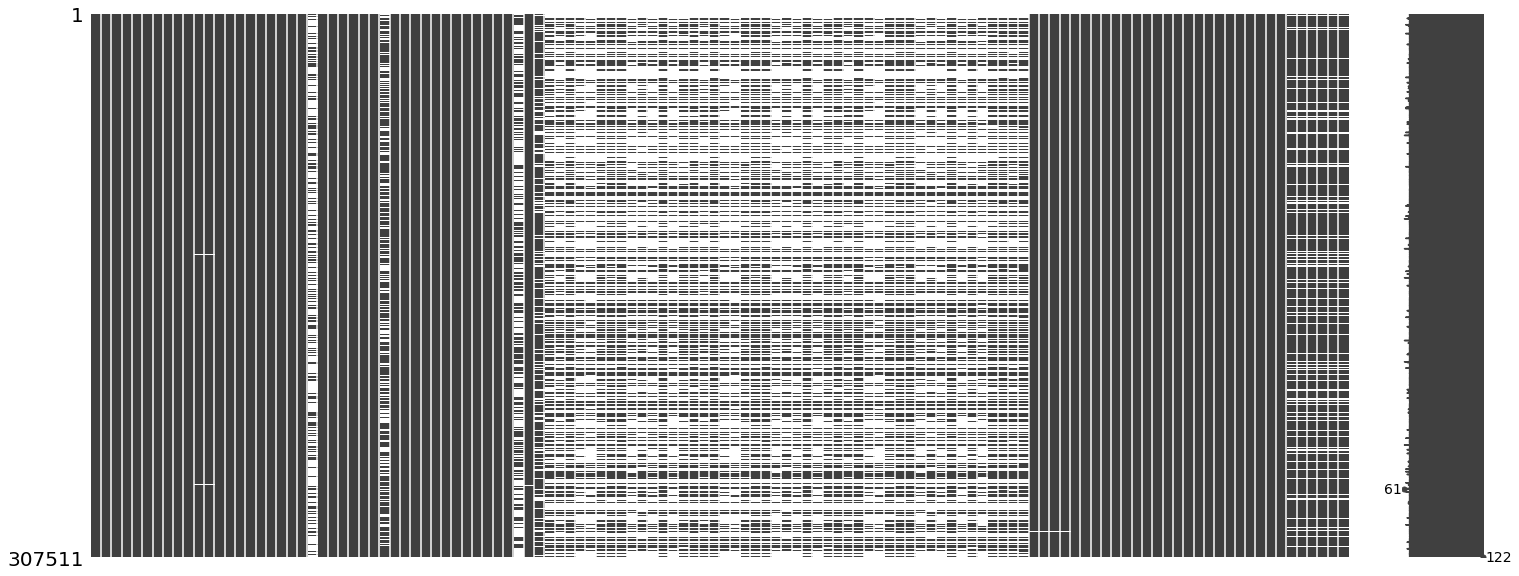

In [25]:
# Use missingno tool to get a big picture of missing values in each column
msno.matrix(application_train_df);

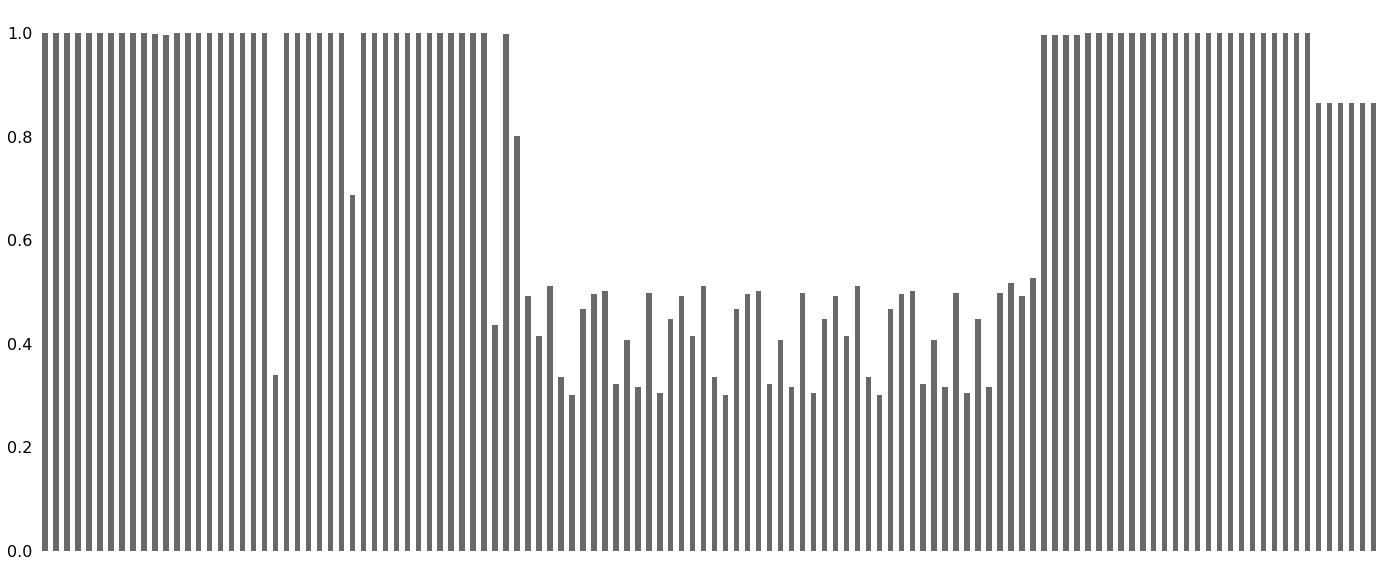

In [26]:
# Use missingno tool to show the percentage of non-NaN values in each column
msno.bar(application_train_df);

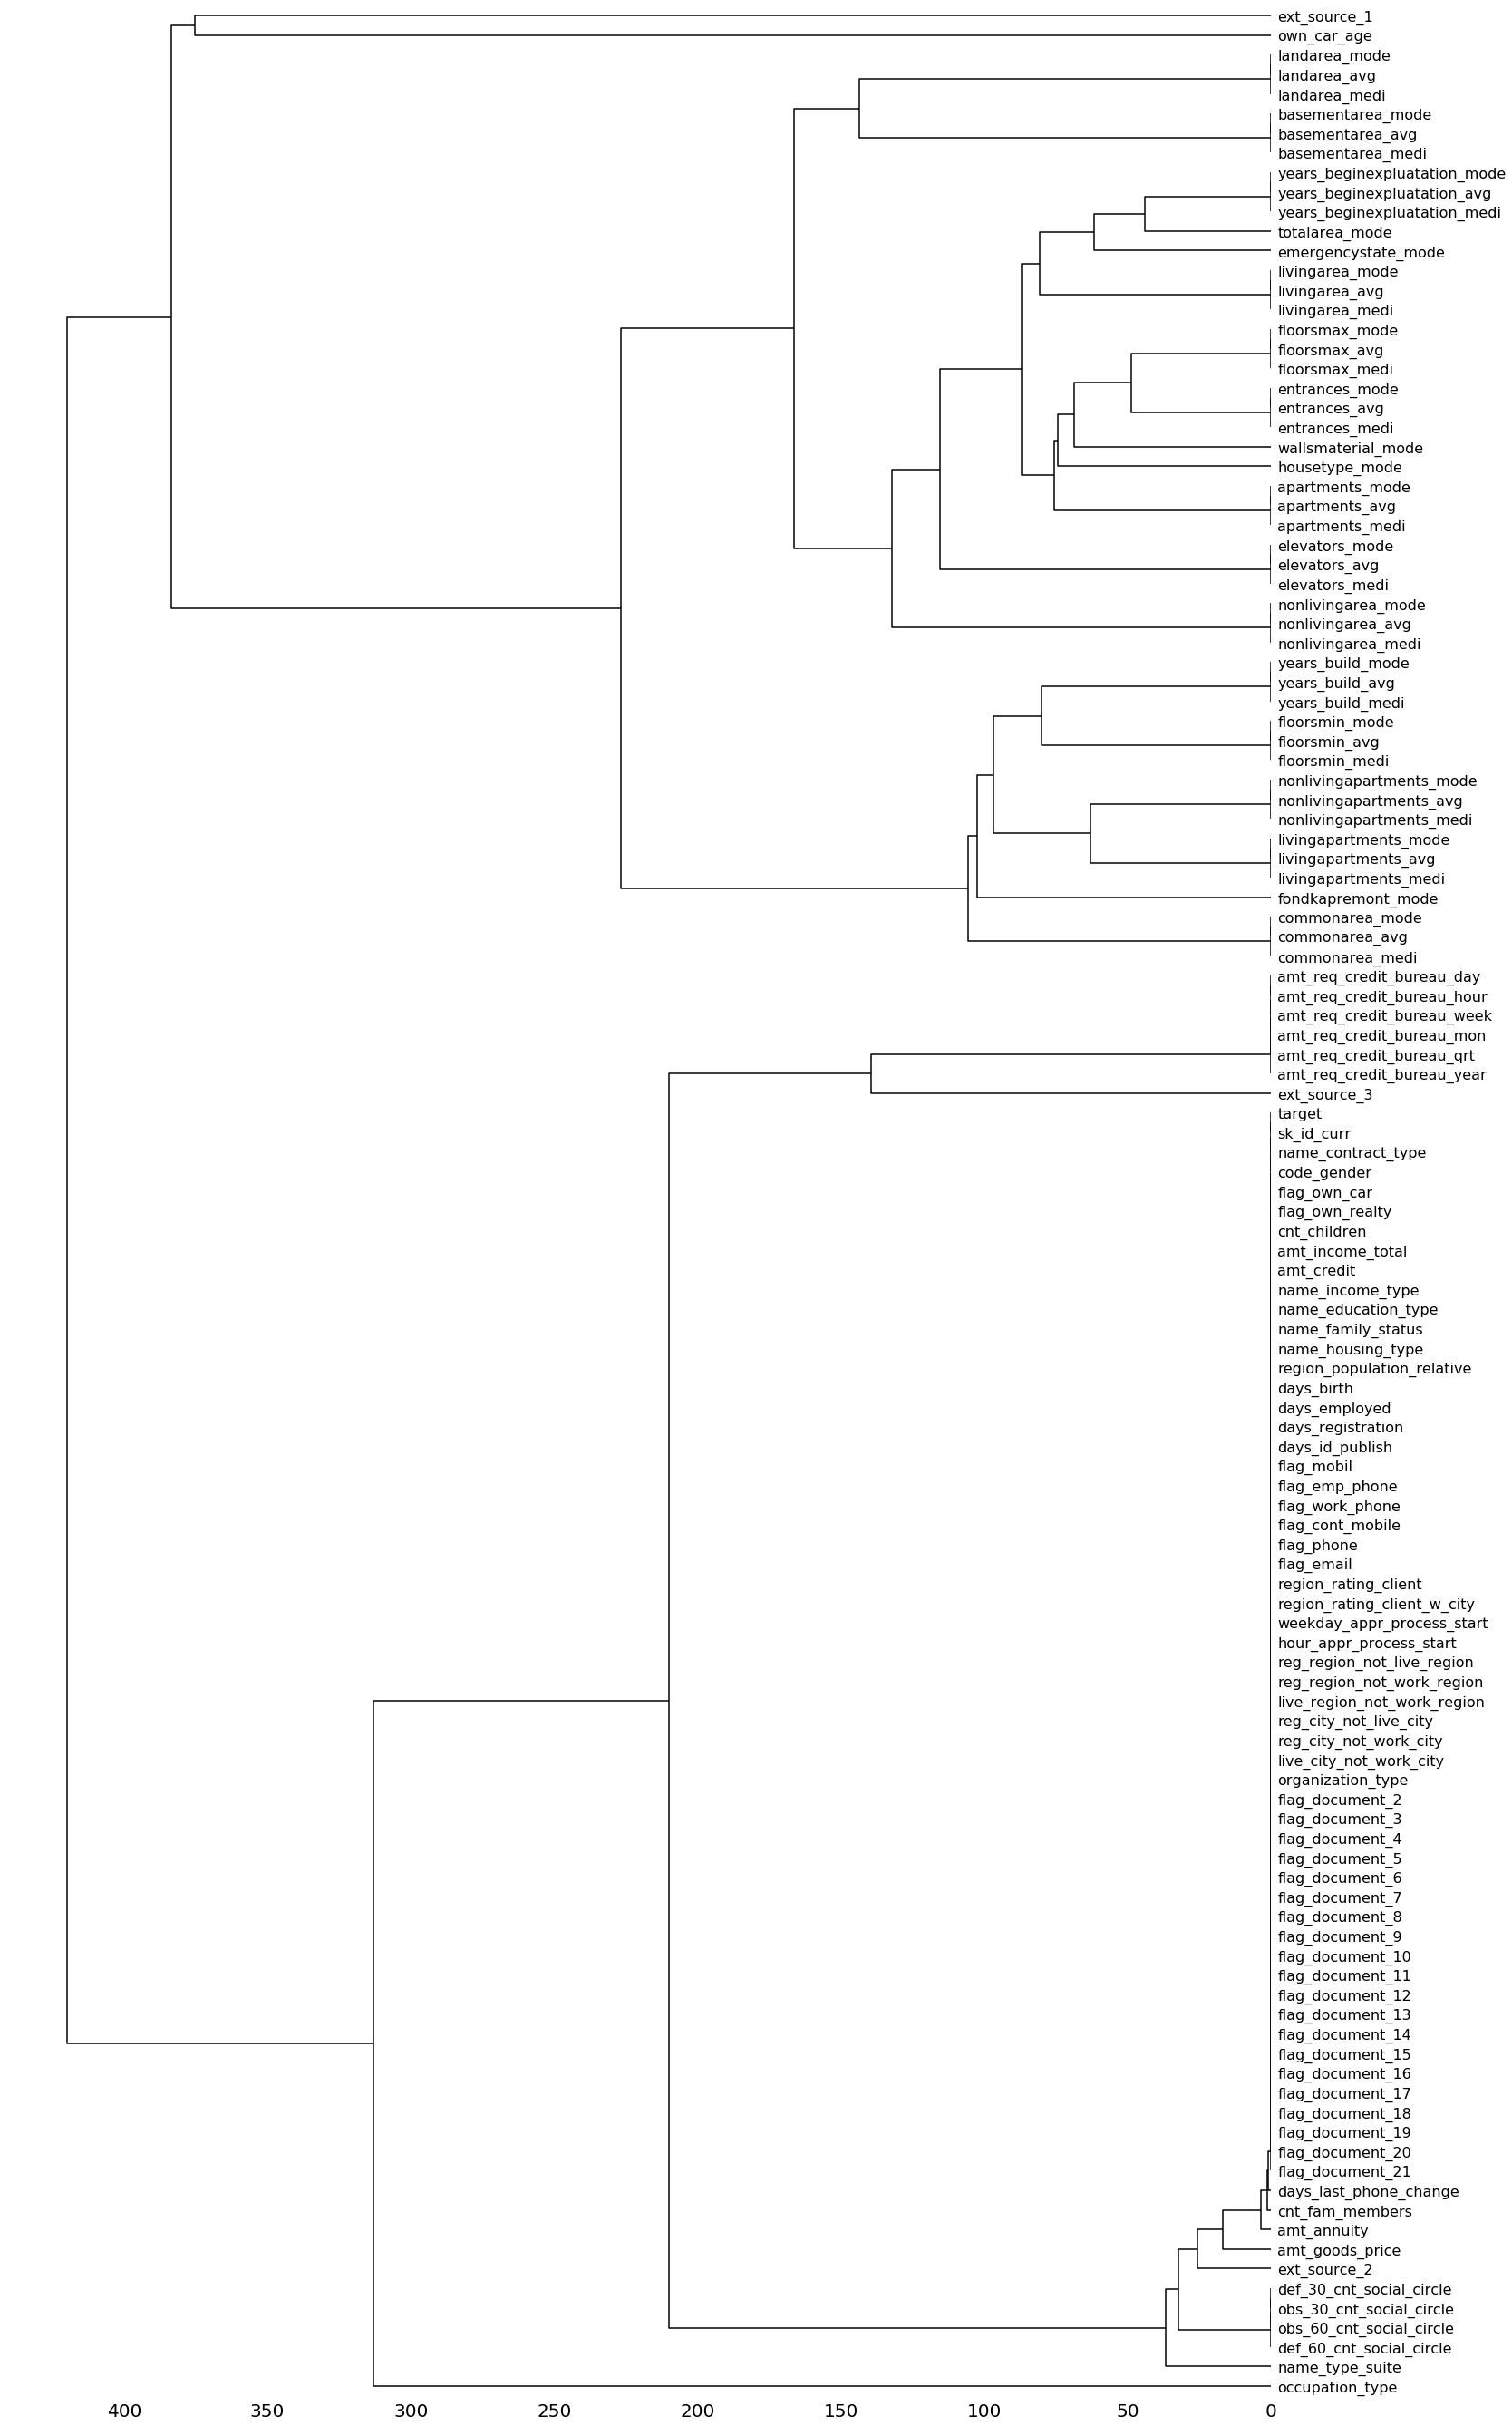

In [27]:
# This shows the hierarchical tree representing groupings of columns that have strong nullity correlations
msno.dendrogram(application_train_df);

### Turning NaN Values to New Features

In [28]:
# Create a new feature that records if 'ext_source_1' is null or not
application_train_df['nan_ext_source_1'] = application_train_df['ext_source_1'].transform(lambda x: is_nan(x))

In [29]:
# Find out the percentages of paid-off and defaulted loans for observation with missing ext_source_1 value
application_train_df[application_train_df['nan_ext_source_1']==1].target.value_counts()\
/len(application_train_df[application_train_df['nan_ext_source_1']==1])

0    0.914805
1    0.085195
Name: target, dtype: float64

In [19]:
# Find out the percentages of paid-off and defaulted loans for observation without missing ext_source_1 value
application_train_df[application_train_df['nan_ext_source_1']!=1].target.value_counts()\
/len(application_train_df[application_train_df['nan_ext_source_1']!=1])

0    0.925045
1    0.074955
Name: target, dtype: float64

It looks liks observations with missing ext_source_1 feature are 14% more likely to be loan default

In [20]:
# Create a new feature 'null_percent_house_info' that records the percentage of missing house infomation
house_features = [i for i in application_train_df.columns if re.search('_mode|_avg|_medi', i)]
application_train_df['null_percent_house_info'] = (application_train_df[house_features].isnull().sum(axis=1)*100
                                                   /len(application_train_df[house_features].columns))

In [21]:
# Find out the percentages of paid-off and defaulted loans for observation with missing house info more than 50%
application_train_df[application_train_df['null_percent_house_info']>=50].target.value_counts()\
/len(application_train_df[application_train_df['null_percent_house_info']>=50])

0    0.909245
1    0.090755
Name: target, dtype: float64

In [22]:
# Find out the percentages of paid-off and defaulted loans for observation with missing house info less than 50%
application_train_df[application_train_df['null_percent_house_info']<50].target.value_counts()\
/len(application_train_df[application_train_df['null_percent_house_info']<50].target)

0    0.931008
1    0.068992
Name: target, dtype: float64

It looks like observations with more than 50% missing house information are 32% more likely to be loan default

In [23]:
# Keep the new feature 'null_percent_house_info' and drop all house information features
application_train_df = application_train_df.drop(columns=house_features)

### Cleaning Age and Gender Features

In [24]:
# Converting age by days to years
application_train_df['days_birth'] = application_train_df['days_birth'].transform(lambda x: round(abs(x/365),1))
application_train_df = application_train_df.rename(columns={'days_birth':'age'});

In [25]:
# Change 'XNA' to 'F' in feature 'code_gender'. ' XNA' is less than 0.1% of total observation.
application_train_df['code_gender'] = application_train_df.code_gender.str.replace('XNA','F')

### Analyzing Anomaly of Employment Information

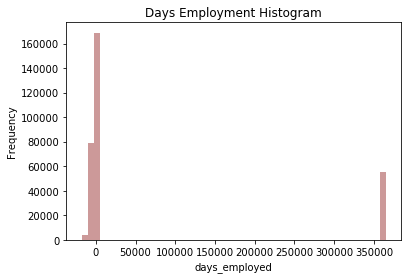

In [26]:
# Display the days of employment information using histogram
sns.distplot(application_train_df.days_employed, bins=50, color='maroon',kde=False)
plt.title('Days Employment Histogram')
plt.ylabel('Frequency');

In [27]:
# Shows the counts of employment information
application_train_df.days_employed.value_counts().head()

 365243    55374
-200         156
-224         152
-199         151
-230         151
Name: days_employed, dtype: int64

The positive 365243 days from loan application date is impossible because it means 1000 years in the future. Since there are significant entries with this value, it must indicate something. Next is to analysis if this value has different loan default rate.

In [28]:
# Find out the percentages defaulted loans for observation with and without the employment anomaly
days_employed_anomaly = application_train_df[application_train_df['days_employed'] == 365243]
days_employed_normal = application_train_df[application_train_df['days_employed'] != 365243]
print('Default rate of days_employed_anomaly:', round((100 * days_employed_anomaly['target'].mean()),2),'%')
print('Default rate of days_employed_normal:', round((100 * days_employed_normal['target'].mean()),2),'%')

Default rate of days_employed_anomaly: 5.4 %
Default rate of days_employed_normal: 8.66 %


Looks like the 1000 year future employment entries have lower loan default rate. A new column will be created to record this anomaly and the days_employed columns with this value will be set to NaN and have them filled with median values using imputation.

In [29]:
# Create a new feature 'days_employed_anomaly' to record the anomly and change the anomaly value in 'days_employed'
# feature to NaN values
application_train_df['days_employed_anomaly'] = application_train_df['days_employed'].transform(lambda x: 1 if x == 365243 else 0)
application_train_df['days_employed'] = application_train_df['days_employed'].replace({365243: np.nan})

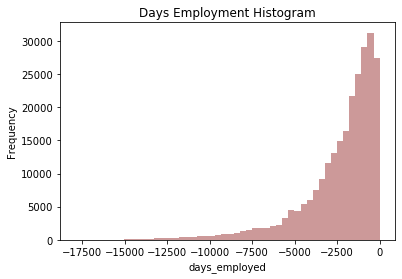

In [30]:
# Display the days of employment information using histogram again 
sns.distplot(application_train_df.days_employed, bins=50, color='maroon',kde=False)
plt.title('Days Employment Histogram')
plt.ylabel('Frequency');

In [31]:
application_train_df.head(1)

,sk_id_curr,target,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,name_type_suite,name_income_type,name_education_type,name_family_status,name_housing_type,region_population_relative,age,days_employed,days_registration,days_id_publish,own_car_age,flag_mobil,flag_emp_phone,flag_work_phone,flag_cont_mobile,flag_phone,flag_email,occupation_type,cnt_fam_members,region_rating_client,region_rating_client_w_city,weekday_appr_process_start,hour_appr_process_start,reg_region_not_live_region,reg_region_not_work_region,live_region_not_work_region,reg_city_not_live_city,reg_city_not_work_city,live_city_not_work_city,organization_type,ext_source_1,ext_source_2,ext_source_3,obs_30_cnt_social_circle,def_30_cnt_social_circle,obs_60_cnt_social_circle,def_60_cnt_social_circle,days_last_phone_change,flag_document_2,flag_document_3,flag_document_4,flag_document_5,flag_document_6,flag_document_7,flag_document_8,flag_document_9,flag_document_10,flag_document_11,flag_document_12,flag_document_13,flag_document_14,flag_document_15,flag_document_16,flag_document_17,flag_document_18,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year,nan_ext_source_1,null_percent_house_info,days_employed_anomaly
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,25.9,-637.0,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0,0.0,0


### Domain Features

In [32]:
# Engineer new features using domain knowledge
df_with_domain_features = application_train_df.copy()
df_with_domain_features['credit_income_ratio'] = df_with_domain_features['amt_credit']\
                                                    / df_with_domain_features['amt_income_total']
df_with_domain_features['annuity_income_ratio'] = df_with_domain_features['amt_annuity']\
                                                    / df_with_domain_features['amt_income_total']
df_with_domain_features['credit_period'] = df_with_domain_features['amt_annuity']\
                                                    / df_with_domain_features['amt_credit']
df_with_domain_features['employment_age_ratio'] = df_with_domain_features['days_employed']\
                                                    / (-365 * df_with_domain_features['age'])

In [33]:
df_with_domain_features.head(1)

,sk_id_curr,target,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,name_type_suite,name_income_type,name_education_type,name_family_status,name_housing_type,region_population_relative,age,days_employed,days_registration,days_id_publish,own_car_age,flag_mobil,flag_emp_phone,flag_work_phone,flag_cont_mobile,flag_phone,flag_email,occupation_type,cnt_fam_members,region_rating_client,region_rating_client_w_city,weekday_appr_process_start,hour_appr_process_start,reg_region_not_live_region,reg_region_not_work_region,live_region_not_work_region,reg_city_not_live_city,reg_city_not_work_city,live_city_not_work_city,organization_type,ext_source_1,ext_source_2,ext_source_3,obs_30_cnt_social_circle,def_30_cnt_social_circle,obs_60_cnt_social_circle,def_60_cnt_social_circle,days_last_phone_change,flag_document_2,flag_document_3,flag_document_4,flag_document_5,flag_document_6,flag_document_7,flag_document_8,flag_document_9,flag_document_10,flag_document_11,flag_document_12,flag_document_13,flag_document_14,flag_document_15,flag_document_16,flag_document_17,flag_document_18,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year,nan_ext_source_1,null_percent_house_info,days_employed_anomaly,credit_income_ratio,annuity_income_ratio,credit_period,employment_age_ratio
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,25.9,-637.0,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0,0.0,0,2.007889,0.121978,0.060749,0.067382


### Combining Features from Bureau and Previous Application Databases

In [34]:
# Get data from pickle file from Bureau database and Previous Application database
with open('bureau_transfer.pickle', 'rb') as read_file:
    bureau_transfer_df = pickle.load(read_file)
    
with open('prev_application_transfer.pickle', 'rb') as read_file:
    prev_application_transfer_df = pickle.load(read_file)

df_with_domain_features = pd.merge(df_with_domain_features,bureau_transfer_df, on='sk_id_curr', how='outer')
df_with_domain_features = pd.merge(df_with_domain_features,prev_application_transfer_df, on='sk_id_curr', how='outer')

### Data Preparation for Model Training and Testing

In [35]:
# Splitting data to independent and dependent variables
sk_id_curr = pd.DataFrame(application_train_df.iloc[:,0])
y = application_train_df.iloc[:,0:2]
X = application_train_df.drop(columns=['target'])
y_domain = df_with_domain_features.iloc[:,0:2]
X_domain = df_with_domain_features.drop(columns=['target'])

In [36]:
print('Base: Data classes before splitting: ',sorted(Counter(y.iloc[:,1]).items()))
print('Domain: Data classes before splitting: ',sorted(Counter(y_domain.iloc[:,1]).items()))

Base: Data classes before splitting:  [(0, 282686), (1, 24825)]
Domain: Data classes before splitting:  [(0, 282686), (1, 24825)]


In [37]:
# Split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y.iloc[:,1], test_size=0.2, random_state=88)
X_train_domain, X_test_domain, y_train_domain, y_test_domain =\
                train_test_split(X_domain, y_domain, stratify=y_domain.iloc[:,1], test_size=0.2, random_state=88)
print('Data classes after splitting')
print('Base Train data: ',sorted(Counter(y_train.iloc[:,1]).items()))
print('Base Test data: ',sorted(Counter(y_test.iloc[:,1]).items()))
print('Domain Train data: ',sorted(Counter(y_train_domain.iloc[:,1]).items()))
print('Domain Test data: ',sorted(Counter(y_test_domain.iloc[:,1]).items()))

Data classes after splitting
Base Train data:  [(0, 226148), (1, 19860)]
Base Test data:  [(0, 56538), (1, 4965)]
Domain Train data:  [(0, 226148), (1, 19860)]
Domain Test data:  [(0, 56538), (1, 4965)]


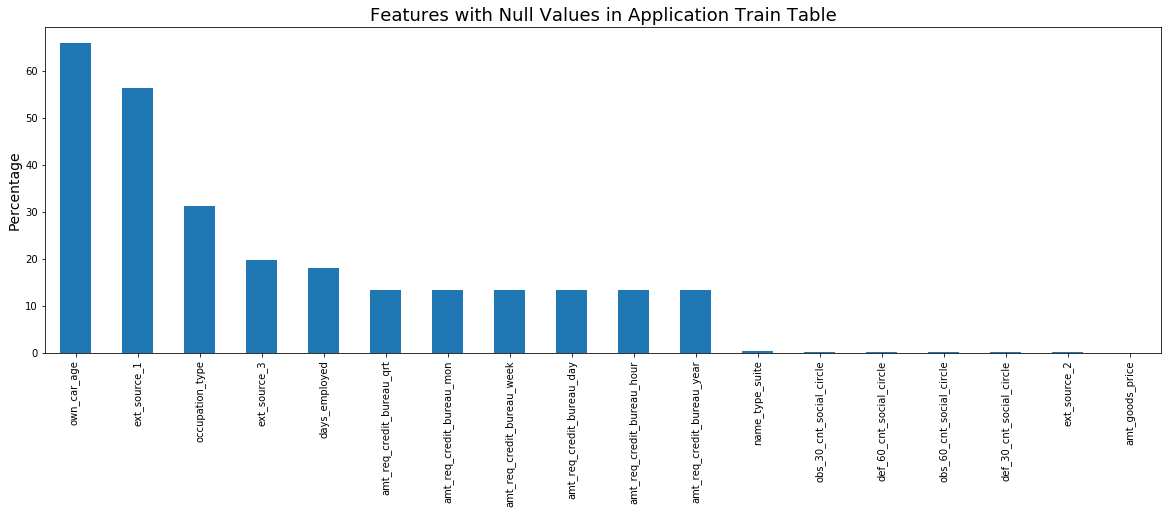

In [38]:
# Shows the features with null values and the precentage of null values
features_null_percentage = nan_percentage(X_train)
features_null_percentage.loc[lambda x : x!=0].plot(kind='bar', figsize=(20,6))
plt.title('Features with Null Values in Application Train Table', size='18')
plt.ylabel('Percentage', size='14');

In [39]:
# This function fills the NaN cells with median for float and int and with most frequent values for categories
def fillna4_train_test(df_train, df_test):
    for col in df_train:
        #get dtype for column
        dt = df_train[col].dtype 
        #check if it is a number
        if dt == int or dt == float:
            median = df_train[col].median()
            df_train[col] = df_train[col].fillna(median)
            df_test[col] = df_test[col].fillna(median)
        else:
            frequent = df_train[col].value_counts().index[0]
            df_train[col] = df_train[col].fillna(frequent)
            df_test[col] = df_test[col].fillna(frequent)

In [40]:
# Apply fillna4_train_test function to train and test data
fillna4_train_test(X_train,X_test)
fillna4_train_test(X_train_domain,X_test_domain)

### Polynomial Features

In [ ]:
# Make a new dataframe for polynomial features
poly_fea_train = X_train_domain[['ext_source_1', 'ext_source_2', 'ext_source_3', 'age']]
poly_fea_test = X_test_domain[['ext_source_1', 'ext_source_2', 'ext_source_3', 'age']]

# Create the polynomial object with specified degree
poly = PolynomialFeatures(degree = 3)

print(poly_fea_train.shape,poly_fea_test.shape)

In [ ]:
# Train the polynomial features
poly.fit(poly_fea_train)

# Transform the features
poly_fea_train = poly.transform(poly_fea_train)
poly_fea_test = poly.transform(poly_fea_test)
print('Train: Polynomial Features shape: ', poly_fea_train.shape)
print('Test: Polynomial Features shape: ', poly_fea_test.shape)

In [ ]:
poly_features_name = poly.get_feature_names(input_features = ['ext_source_1', 'ext_source_2', 'ext_source_3', 'age'])

In [ ]:
poly_fea_train = pd.DataFrame(poly_fea_train, columns=poly_features_name).drop(columns=[
    '1','ext_source_1', 'ext_source_2', 'ext_source_3', 'age'])
poly_fea_train = pd.DataFrame(X_train_domain.reset_index(drop='index')['sk_id_curr']).join(
    poly_fea_train, how='outer')

poly_fea_test = pd.DataFrame(poly_fea_test, columns=poly_features_name).drop(columns=[
    '1','ext_source_1', 'ext_source_2', 'ext_source_3', 'age'])
poly_fea_test = pd.DataFrame(X_test_domain.reset_index(drop='index')['sk_id_curr']).join(
    poly_fea_test, how='outer')

In [ ]:
X_train_domain = X_train_domain.merge(poly_fea_train, on ='sk_id_curr', how = 'left')
X_test_domain = X_test_domain.merge(poly_fea_test, on ='sk_id_curr', how = 'left')

In [ ]:
print('Train and test data after combining with polynomial features')
print('Train: Polynomial Features shape: ', X_train_domain.shape)
print('Test: Polynomial Features shape: ', X_test_domain.shape)

### Save Progress in Pickle files

In [41]:
# Save dataframes into pickles to be used later
with open('simple_X_train.pickle', 'wb') as to_write:
    pickle.dump(X_train, to_write)
    
with open('simple_X_test.pickle', 'wb') as to_write:
    pickle.dump(X_test, to_write)

with open('domain_X_train.pickle', 'wb') as to_write:
    pickle.dump(X_train_domain, to_write)
    
with open('domain_X_test.pickle', 'wb') as to_write:
    pickle.dump(X_test_domain, to_write)
    
with open('simple_y_train.pickle', 'wb') as to_write:
    pickle.dump(y_train, to_write)

with open('simple_y_test.pickle', 'wb') as to_write:
    pickle.dump(y_test, to_write)

with open('domain_y_train.pickle', 'wb') as to_write:
    pickle.dump(y_train_domain, to_write)

with open('domain_y_test.pickle', 'wb') as to_write:
    pickle.dump(y_test_domain, to_write)

### Load Data from Pickle files

In [79]:
# Get data from pickle files
with open('simple_X_train.pickle', 'rb') as read_file:
    X_train = pickle.load(read_file)
    
with open('simple_X_test.pickle', 'rb') as read_file:
    X_test = pickle.load(read_file)

with open('domain_X_train.pickle', 'rb') as read_file:
    X_train_domain = pickle.load(read_file)
    
with open('domain_X_test.pickle', 'rb') as read_file:
    X_test_domain = pickle.load(read_file)
    
with open('simple_y_train.pickle', 'rb') as read_file:
    y_train = pickle.load(read_file)

with open('simple_y_test.pickle', 'rb') as read_file:
    y_test = pickle.load(read_file)

with open('domain_y_train.pickle', 'rb') as read_file:
    y_train_domain = pickle.load(read_file)

with open('domain_y_test.pickle', 'rb') as read_file:
    y_test_domain = pickle.load(read_file)

In [80]:
# Only keep 'target' in the y variables
sk_id_curr_train = pd.DataFrame(y_train.iloc[:,0])
sk_id_curr_test = pd.DataFrame(y_test.iloc[:,0])
y_train = y_train.iloc[:,1]
y_test = y_test.iloc[:,1]

sk_id_curr_train_domain = pd.DataFrame(y_train_domain.iloc[:,0])
sk_id_curr_test_domain = pd.DataFrame(y_test_domain.iloc[:,0])
y_train_domain = y_train_domain.iloc[:,1]
y_test_domain = y_test_domain.iloc[:,1]

In [81]:
# Apply one hot encoding to all categorical features and drop one category for each feature
X_train = pd.get_dummies(X_train.iloc[:,1:], drop_first=True)
X_test = pd.get_dummies(X_test.iloc[:,1:], drop_first=True)

X_train_domain = pd.get_dummies(X_train_domain.iloc[:,1:], drop_first=True)
X_test_domain = pd.get_dummies(X_test_domain.iloc[:,1:], drop_first=True)

In [82]:
print('Base:')
print(X_train.shape, X_test.shape)
print('Domain:')
print(X_train_domain.shape, X_test_domain.shape)

Base:
(246008, 175) (61503, 174)
Domain:
(246008, 267) (61503, 266)


Since some columns exist in training data but not in testing data or vice versa, we create the missing columns and fill them with 0.

In [83]:
# Make sure both train and test data have the same dummy variables from one hot encoding
X_train, X_test = equalize_df_columns(X_train, X_test)
X_train_domain, X_test_domain = equalize_df_columns(X_train_domain, X_test_domain)

In [85]:
print('Base:')
print(X_train.shape, X_test.shape)
print('Domain:')
print(X_train_domain.shape, X_test_domain.shape)

Base:
(246008, 175) (61503, 175)
Domain:
(246008, 154) (61503, 154)


In [86]:
print('Base:')
print('Train data: ',sorted(Counter(y_train).items()))
print('Test data: ',sorted(Counter(y_test).items()))
print('Domain:')
print('Train data: ',sorted(Counter(y_train_domain).items()))
print('Test data: ',sorted(Counter(y_test_domain).items()))

Base:
Train data:  [(0, 226148), (1, 19860)]
Test data:  [(0, 56538), (1, 4965)]
Domain:
Train data:  [(0, 226148), (1, 19860)]
Test data:  [(0, 56538), (1, 4965)]


### Undersampling and Oversampling

In [87]:
# Scale data using StandardScaler
scalar = StandardScaler()
X_train_scaled = scalar.fit_transform(X_train)
X_test_scaled = scalar.transform(X_test)
X_train_domain_scaled = scalar.fit_transform(X_train_domain)
X_test_domain_scaled = scalar.transform(X_test_domain)

In [ ]:
# Apply undersampling due to imbalanced classes
rus = RandomUnderSampler(random_state=77)
X_train_scaled, y_train = rus.fit_resample(X_train_scaled, y_train)
print('Train data: ',sorted(Counter(y_train).items()))
print('Test data: ',sorted(Counter(y_test).items()))

In [ ]:
# Apply simple overampling due to imbalanced classes
y_train2 = y_train.copy()
ros = RandomOverSampler(random_state=77)
ros_resample = RandomOverSampler(random_state=77)
X_train, y_train = ros.fit_resample(X_train, y_train)
X_train_scaled, y_train2 = ros_resample.fit_resample(X_train_scaled, y_train2)
print('Train data: ',sorted(Counter(y_train).items()))
print('Test data: ',sorted(Counter(y_test).items()))

In [ ]:
# Apply SMOTE due to imbalanced classes
smote = SMOTE(random_state=77)
X_train_scaled, y_train = smote.fit_resample(X_train_scaled, y_train)
print('Train data: ',sorted(Counter(y_train).items()))
print('Test data: ',sorted(Counter(y_test).items()))

In [ ]:
# Apply SMOTE due to imbalanced classes (Domain)
smote = SMOTE(random_state=77)
X_train_domain_scaled, y_train_domain = smote.fit_resample(X_train_domain_scaled, y_train_domain)
print('Domain Train data: ',sorted(Counter(y_train).items()))
print('Domain Test data: ',sorted(Counter(y_test).items()))

In [ ]:
# Apply ADAYSN due to imbalanced classes
adaysn = ADASYN(random_state=77)
X_train_scaled, y_train = adaysn.fit_resample(X_train_scaled, y_train)
print('Train data: ',sorted(Counter(y_train).items()))
print('Test data: ',sorted(Counter(y_test).items()))

In [88]:
# Apply ADAYSN due to imbalanced classes (DOMAIN)
adaysn = ADASYN(random_state=77)
X_train_domain_scaled, y_train_domain = adaysn.fit_resample(X_train_domain_scaled, y_train_domain)
print('Domain Train data: ',sorted(Counter(y_train_domain).items()))
print('Domain Test data: ',sorted(Counter(y_test_domain).items()))

Domain Train data:  [(0, 226148), (1, 224449)]
Domain Test data:  [(0, 56538), (1, 4965)]


In [26]:
# Use StratifiedKFold to prevent missing minority data in train or test data
skf = StratifiedKFold(n_splits=5, random_state=77, shuffle=True)

### Cross Validate Checks of all Models

In [90]:
X_train_scaled = X_train_domain_scaled
X_test_scaled = X_test_domain_scaled
y_train = y_train_domain
y_test = y_test_domain

In [27]:
# Perform cross validation using Logistic Regression and display the results
logit_cv = cross_validate(LogisticRegression(C=0.00005, penalty='l2', solver='newton-cg', random_state=77),
                          X_train_scaled, y_train, cv=skf, 
                          scoring=('accuracy', 'f1', 'precision', 'recall','roc_auc'), 
                          return_train_score=True)
report_cv_results(logit_cv)

Cross Validation Averages:
fit_time : 13.013883304595947
score_time : 0.1566908359527588
test_accuracy : 0.7093345025477997
train_accuracy : 0.7096074759497704
test_f1 : 0.7118571988124641
train_f1 : 0.7121017509158186
test_precision : 0.7031256150907661
train_precision : 0.7034300454904558
test_recall : 0.7208096236154823
train_recall : 0.7209900688954466
test_roc_auc : 0.7759978729317245
train_roc_auc : 0.7763193749546393


In [ ]:
# Perform cross validation using BernoulliNB and display the results
bernoulliNB_cv = cross_validate(BernoulliNB(alpha=1.0, binarize=0.0), X_train_scaled, y_train, cv=skf, 
                              scoring=('accuracy','f1', 'precision', 'recall','roc_auc'), return_train_score=True)
report_cv_results(bernoulliNB_cv)

In [29]:
# Perform cross validation using Random Forest and display the results
rf_cv = cross_validate(RandomForestClassifier(bootstrap=True, max_depth= 3, n_estimators=150, random_state=77),
                       X_train_scaled, y_train, cv=skf, scoring=('accuracy', 'f1', 'precision', 'recall','roc_auc'),
                       return_train_score=True)
report_cv_results(rf_cv)

In [ ]:
# Perform cross validation using XGBoost and display the results
XGB_cv = cross_validate(XGBClassifier(learningrate =0.01, nestimators=10000, maxdepth=4, minchildweight=4,
                                      subsample=0.8, colsamplebytree=0.5, objective= 'binary:logistic', nthread=4,
                                      scaleposweight=2, seed=27), X_train_scaled, y_train, cv=skf, 
                        scoring=('accuracy', 'f1', 'precision', 'recall','roc_auc'), return_train_score=True)
report_cv_results(XGB_cv)

### GridSearchCV

In [ ]:
# Choose Random Forest as the classifier. 
rf_clf = RandomForestClassifier(random_state=77)

# Choose some parameter combinations to try
parameters = {'n_estimators': [80, 100, 120], 
              'max_features': ['log2', 'sqrt','auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [2, 5, 8], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1, 5, 8]
             }
# Type of scoring used to compare parameter combinations
scorer = make_scorer(roc_auc_score, precision_score, recall_score)

# Run the grid search
grid_obj = GridSearchCV(rf_clf, parameters, scoring=(scorer), cv=skf)
grid_obj = grid_obj.fit(X_train_scaled, y_train)

# Set the rf_clf to the best combination of parameters
rf_clf = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
rf_clf.fit(X_train_scaled, y_train)

In [ ]:
rf_predictions = rf_clf.predict(X_test_scaled)
print('Accuracy using GridsearchCV(Random_Forest): ', accuracy_score(y_test, rf_predictions))
print('Precision using GridsearchCV(Random_Forest): ', precision_score(y_test, rf_predictions))
print('Recall using GridsearchCV(Random_Forest): ', recall_score(y_test, rf_predictions))
print('F1 using GridsearchCV(Random_Forest): ', f1_score(y_test, rf_predictions))
print('ROC AUC using GridsearchCV(Random_Forest): ', roc_auc_score(y_test, rf_clf.predict_proba(X_test_scaled)[:,1]))

In [ ]:
# Choose Logistic Regression as the classifier. 
logreg = LogisticRegression(random_state=77)

# Choose some parameter combinations to try
parameters = {'C': [0.0001, 0.001, 0.01, 0.1], 
              #'penalty':['l2'],
              'solver' :['liblinear','newton-cg', 'lbfgs','saga']}

# Type of scoring used to compare parameter combinations
scorer = make_scorer(roc_auc_score, precision_score, recall_score)

# Run the grid search
grid_obj = GridSearchCV(logreg, parameters, scoring=scorer, cv=skf)
grid_obj = grid_obj.fit(X_train_scaled,y_train)

# Set the logreg to the best combination of parameters
logreg = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
logreg.fit(X_train_scaled, y_train)

In [ ]:
logit_predictions = logreg.predict(X_test_scaled)
print('Accuracy using GridsearchCV(Logistic Regression): ', accuracy_score(y_test, logit_predictions))
print('Precision using GridsearchCV(Logistic Regression): ', precision_score(y_test, logit_predictions))
print('Recall using GridsearchCV(Logistic Regression): ', recall_score(y_test, logit_predictions))
print('F1 using GridsearchCV(Logistic Regression): ', f1_score(y_test, logit_predictions))
print('ROC AUC using GridsearchCV(Logistic Regression): ', roc_auc_score(y_test, logreg.predict_proba(X_test_scaled)[:,1]))

### Fitting & Predicting using Random Forest with Best Hyperparameters

In [18]:
# Fit data to Random Forest
rf = RandomForestClassifier(bootstrap=True, max_depth= 5, n_estimators=100, random_state=77)
rf.fit(X_train_scaled , y_train);

< Random Forest Scores>
Accuracy: 0.8207729704242069
Log Loss: 6.190381781712052
Precision: 0.17239887518927102
F1: 0.22433326296530856
Recall :0.32104733131923463
ROC AUC: 0.6800577262386815


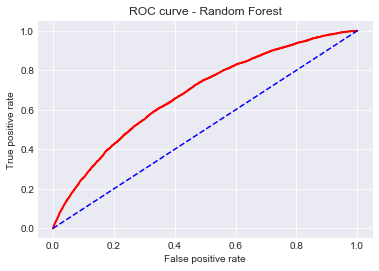

In [21]:
show_model_metrics(rf, y_test, X_test_scaled, 'Random Forest')

In [22]:
# Interactive confusion matrix with threshold sldier! 
interactive(lambda threshold: interactive_confusion_matrix(rf, y_test, X_test_scaled , 'Random Forest',
                                                           threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

In [24]:
# Show feature importances from Random Forest
feature_importance_df = rf_feature_importance_report(rf, X_train_domain.columns)
feature_importance_df 

,features,feature_importance
0,ext_source_2,0.083236
1,bu_amt_credit_sum_debt,0.069966
2,prev_name_yield_group_low_normal,0.061007
3,bu_credit_type_Credit card,0.060146
4,ext_source_3,0.046902
5,flag_phone,0.041490
6,flag_own_car_Y,0.037492
7,name_education_type_Higher education,0.035726
8,prev_name_yield_group_high,0.034993
9,null_percent_house_info,0.031158


In [70]:
# Create important feature list
rf_important_features_list = list(feature_importance_df[feature_importance_df['feature_importance']!=0]['features'])

In [98]:
# Save important feature list into pickle file
with open('best_features_final_11sep2019_1839', 'wb') as to_write:
    pickle.dump(rf_important_features_list, to_write)

### Fitting & Predicting using Logistic Regression with Best Hyperparameters

In [13]:
# Fit data to Logistic Regression
logit = LogisticRegression(C=0.00005, penalty='l2', solver='newton-cg', random_state=77)
logit.fit(X_train_scaled,y_train)

LogisticRegression(C=5e-05, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=77, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

< Logistic Regression Scores>
Accuracy: 0.6912670926621466
Log Loss: 10.663482314768359
Precision: 0.16064082087023862
F1: 0.25903379380316865
Recall :0.668479355488419
ROC AUC: 0.7439768713158083


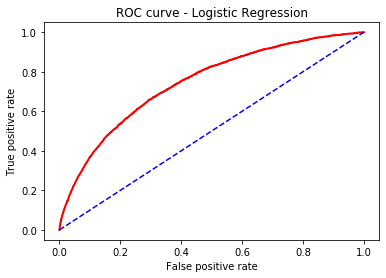

In [14]:
show_model_metrics(logit, y_test, X_test_scaled, 'Logistic Regression')

In [15]:
# Interactive confusion matrix with threshold sldier! 
interactive(lambda threshold: interactive_confusion_matrix(logit, y_test, X_test_scaled , 'Logistic Regression',
                                                           threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

In [17]:
# Get the coefficients of significant features
logit_coef = pd.DataFrame(list(zip(X_train_domain.columns, np.transpose(logit.coef_[0]))))
logit_coef = logit_coef.rename(columns={0:'features',1:'coefficient'})
significant_logit_coef = logit_coef[abs(logit_coef['coefficient'])>0.07].sort_values(by=['coefficient'],
                                                                                     ascending=False)

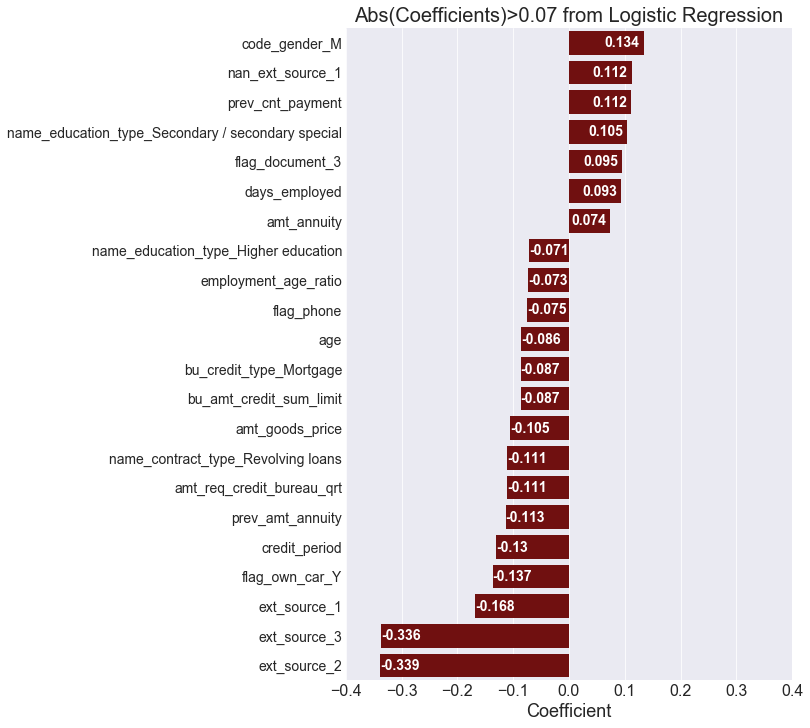

In [18]:
# Plot coefficients of significant features
plt.figure(figsize=(8,12))
plt.style.use('seaborn-darkgrid')
ax = sns.barplot(x='coefficient', y='features', data=significant_logit_coef, color='Maroon')
plt.yticks(size='14')
plt.xticks(size='16')
plt.xlim([-0.4,0.4])
plt.ylabel('')
plt.xlabel('Coefficient',size='18');
plt.title('Abs(Coefficients)>0.07 from Logistic Regression', size='20');
for i, v in enumerate(significant_logit_coef['coefficient']):
    if v>0:
        custom=-0.07
    else:
        custom=0
    plt.text(v+custom, i+0.15, str(round(v,3)), color='white', fontweight='bold', size='14')

### Fitting & Predicting using XGBoost with Best Hyperparameters

In [ ]:
#XGB parameters only for Home Credit
XGB = XGBClassifier(learningrate =0.01, nestimators=10000,
maxdepth=4, minchildweight=4, subsample=0.8, colsamplebytree=0.5,
objective= 'binary:logistic',
nthread=4,
scaleposweight=2,
seed=27)
XGB.fit(X_train_scaled,y_train)

In [ ]:
show_model_metrics(XGB, y_test, X_test_scaled, 'XGBoost')

In [ ]:
# Interactive confusion matrix with threshold sldier! 
interactive(lambda threshold: interactive_confusion_matrix(XGB, y_test, X_test_scaled , 'XGBoost',
                                                           threshold), threshold=(0.0,1.0,0.02))

### Cost-Benefit Analysis

In [19]:
# Value below are based on best effort from my online research. They are equivalent values in US$. Loans are assumed 
# to be from Phillipines

# Benefit of a True Positive - No loss or gain since no loan was given 
BTP = 0
# Benefit of a True Negative - Make money from loan interest
BTN = 920
# Cost of a False Positive - Potential loss revenue from loan interest had loan been given
CFP = -920
# Cost of a False Negative - Loss money from default loan
CFN = -9600

In [20]:
# This function return lists of expected value for every threshold
def cost_benefit_analysis(model, y_test, X_test, step_size=0.01, BTP=0, BTN=0, CFP=0, CFN=0):
    decimal_place = str(step_size)[::-1].find('.')
    x = []
    y = []
    
    for threshold in list(np.arange(0,1+step_size,step_size)):
        threshold = round(threshold,decimal_place)
        
        y_predict = (model.predict_proba(X_test)[:, 1] >= threshold)
        c_mat = confusion_matrix(y_test, y_predict)
        TN = c_mat[0][0]
        FP = c_mat[0][1]
        FN = c_mat[1][0]
        TP = c_mat[1][1]
        ALL = TN+FP+FN+TP

        # Calculate the probabilities for each confusion matrix entry
        TN_proba = TN/ALL
        FP_proba = FP/ALL
        FN_proba = FN/ALL
        TP_proba = TP/ALL

        # Calculate the expected value
        EV = (BTP * TP_proba) + (BTN * TN_proba) + (CFP * FP_proba) + (CFN * FN_proba)
        x.append(threshold)
        y.append(EV)
    return x, y

In [21]:
# This function plots the interactive confusion matrix using list of expect values and their respective thresholds
# cost_benefit_analysia function has to be performed first to get the lists of expected values and thresholds
def interactive_CBA_confusion_matrix(model, y_test, X_test, cba_logit_x, cba_logit_y, model_type, threshold):
    
    # Predict class 1 if probability of being in class 1 is greater than threshold
    y_predict = (model.predict_proba(X_test)[:, 1] >= threshold)
    model_confusion = confusion_matrix(y_test, y_predict)
    
    fig = plt.figure(figsize=(20, 8)) 
    gs = gridspec.GridSpec(1, 2, width_ratios=[2, 2]) 
    ax0 = plt.subplot(gs[0])
    sns.heatmap(model_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['Paid-Off', 'Default'],
           yticklabels=['Paid-Off', 'Default'])
    sns.set(font_scale=1.8)
    #plt.title('Confusion Matrix: '+model_type, size='20');
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    
    
    ax1 = plt.subplot(gs[1])
    plt.plot(cba_logit_x, cba_logit_y, linewidth=3, label='Expected Values: {}'
             .format(round(cba_logit_y[cba_logit_x.index(threshold)],2)))
    plt.plot([threshold,threshold],[min(cba_logit_y)-10,max(cba_logit_y)+10], linewidth=2,
             label='Threshold: {}'.format(threshold),
             linestyle = 'dashed')
    plt.legend(loc = 'lower right', fontsize='16')
    plt.title('Expected Value VS Threshold', size='18')
    plt.xticks(size='20')
    plt.yticks(size='20');

In [24]:
# Run functions 'cost_benefit_analysis' and 'interactive_CBA_confusion_matrix' using local currency
cba_logit_x, cba_logit_y = cost_benefit_analysis(logit, y_test, X_test_scaled, step_size=0.01, BTP=0, 
                                                 BTN=48000, CFP=-48000, CFN=-500000)
interactive(lambda threshold: 
            interactive_CBA_confusion_matrix(logit, y_test, X_test_scaled, cba_logit_x, cba_logit_y, 
                                             'Logistic Regression', threshold), threshold=(0.0,1.0,0.01))

In [23]:
# Run functions 'cost_benefit_analysis' and 'interactive_CBA_confusion_matrix' using equivalent US$
cba_logit_x, cba_logit_y = cost_benefit_analysis(logit, y_test, X_test_scaled, step_size=0.01, BTP=0, 
                                                 BTN=920, CFP=-920, CFN=-9600)
interactive(lambda threshold: 
            interactive_CBA_confusion_matrix(logit, y_test, X_test_scaled, cba_logit_x, cba_logit_y, 
                                             'Logistic Regression', threshold), threshold=(0.0,1.0,0.01))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.01), Output()), _dom_cla…

In [25]:
# Show the optimum expected value and its threshold
print(cba_logit_x[cba_logit_y.index(max(cba_logit_y))] , max(cba_logit_y))

0.68 187.3729736760809


### Save Progress in Pickle files

In [215]:
# Save best train and test data ready for modeling into pickles to be used later
with open('final_X_train_scaled.pickle', 'wb') as to_write:
    pickle.dump(X_train_scaled, to_write)
    
with open('final_X_test_scaled.pickle', 'wb') as to_write:
    pickle.dump(X_test_scaled, to_write)

with open('final_X_train_test_scaled_columns.pickle', 'wb') as to_write:
    pickle.dump(list(X_train_domain.columns), to_write)
    
with open('final_y_train.pickle', 'wb') as to_write:
    pickle.dump(y_train, to_write)

with open('final_y_test.pickle', 'wb') as to_write:
    pickle.dump(y_test, to_write)
    
with open('y_predict_proba.pickle', 'wb') as to_write:
    pickle.dump(y_predict_proba, to_write)

### Load Data from Pickle files

In [12]:
# Get data from pickle file
with open('final_X_train_scaled.pickle', 'rb') as read_file:
    X_train_scaled = pickle.load(read_file)
    
with open('final_X_test_scaled.pickle', 'rb') as read_file:
    X_test_scaled = pickle.load(read_file)

with open('final_X_train_test_scaled_columns.pickle', 'rb') as read_file:
    X_train_test_columns = pickle.load(read_file)

with open('final_y_train.pickle', 'rb') as read_file:
    y_train = pickle.load(read_file)

with open('final_y_test.pickle', 'rb') as read_file:
    y_test = pickle.load(read_file)
    
with open('y_predict_proba.pickle', 'rb') as read_file:
    y_predict_proba = pickle.load(read_file)